In [1]:
%%capture
!pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV

In [3]:
"""
Basic Preprocessing to add seasonality and group the data frame into weekly view
"""

def df_caller(name):
    """
    Fetches basic trading info about the stock
    
    :param 1 name: ticker symbol
    :return: dataframe including volume, closing price, opening price, high price (during the day), low price
    """
    df = yf.download(name)
    if len(df) == 0:
        raise NameError

    # Fill any NaN values with prior 
    df = df.fillna(method='ffill').fillna(method='bfill')

    df = df.round(3)

    return df
  
def add_week(df):
    """
    Add starting weekly date to each row - to make our preprocessing easier
    """
    df['Week'] = df.index.to_period('W').map(str).str.split('/').str[0]
    
    # Add weekday as an integer. {Monday: 1, Tuesday: 2, Wednesday: 3, Thursday: 4, Friday: 5}
    df['WeekDay'] = df.index.weekday + 1
    return df
    
def group_into_weekly(df):
    """
    Convert df into weekly table, so that each row contains Monday-Friday data
    """
    # Make a new DataFrame: df_final
    df_final = df[df['WeekDay'] == 5].copy()
    df_final.index = df_final['Week']
    df_final.drop(['Week'], axis=1, inplace=True)
    df_final.columns = [str(col) + "_5" for col in df_final.columns]
    
    # Join each weekday (1~4) with the df_final on the 'Week' column  
    for i in range(4,0,-1):
        df_new = df[df['WeekDay'] == i].copy()    
        df_new.index = df_new['Week']
        df_new.drop(['Week'], axis=1, inplace=True)
        df_new.columns = [str(col) + "_" + str(i) for col in df_new.columns]
        df_final = df_final.join(df_new, on='Week', how='inner') 

    # Extract month and append as a feature
    df_final['Month'] = pd.to_datetime(df_final.index).month

    return df_final

def add_movement(df):
    # Add target variable : {"Up": 2, "Same": 1, "Down": 0}
    delta = df.shift(-1)['Close_5'] - df['Close_5'] 
    df['Target'] = np.where(delta > 0, 1, 0)

    return df

In [4]:
"""
Add relevant financial indicators as new features
"""

def moving_average(df, days):
    """
    Calculates moving average of closing prices
    
    :param 1 df
    :param 2 days: days of window to calculate moving average
    :return: pandas series MA values
    """
    ma = df['Close'].rolling(window = days, min_periods=1).mean()
    ma = ma.round(3)
    return ma


def macd_hist(df):
    """
    Moving Average Convergence Divergence with respect to closing price - Based on difference between 12 & 26 day exponential moving average
    """
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    
    signal = macd.ewm(span=9, adjust=False).mean()
    hist = macd - signal
    
    return hist


def bollinger(df):
    """
    Bollinger Bands Calcluation with respect to closing prices
    """
    price = (df['Close'] + df['High'] + df['Low']) / 3
    sma = moving_average(df, '20D')
    upper = sma + 2 * df['Close'].rolling('20D').std()
    lower = sma - 2 * df['Close'].rolling('20D').std()
    
    return (price - lower) / (upper - lower) 

def rsi(df, days):
    """
    RSI calculation with respect to closing prices
    """
    delta = df['Close'].diff()
    
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)

    ma_up = up.rolling(window = days, min_periods=1).mean()
    ma_down = down.rolling(window = days, min_periods=1).mean()

    res = ma_up / ma_down
    res = 100 - (100/(1 + res))

    return res

def obv(df):
    res = []
    for i in range(0, len(df)):
        if i == 0:
            res.append(df.Volume[i])
        elif df.Close[i] > df.Close[i-1]:
            res.append(res[-1] + df.Volume[i])
        elif df.Close[i] < df.Close[i-1]:
            res.append(res[-1] - df.Volume[i])
        else:
            res.append(res[-1])
    
    return np.array(res)

In [5]:
def preprocessing(symbol):
    # Create df with the company's ticker symbol - Apple Inc. in our example
    df = df_caller(symbol)

    # Add basic financial indicators as features
    df['MACD'] = macd_hist(df)
    df['Bollinger'] = bollinger(df)
    df['RSI'] = rsi(df, 14)
    df['OBV'] = obv(df)

    df = df.fillna(method='bfill')

    # Scale the indicators 
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[['OBV','Bollinger','MACD','RSI']])
    df_scaled = pd.DataFrame(df_scaled, columns=['OBV','Bollinger','MACD','RSI'], index=df.index)

    # Add the scaled df
    df = df.drop(['OBV','Bollinger','MACD','RSI'], axis=1)
    df = pd.concat([df, df_scaled], axis=1)

    # Convert df into weekly view
    df = add_week(df)
    df = group_into_weekly(df)

    # Add target variable: {"Up": 1, "Same/Down": 0}
    df = add_movement(df)

    return df


[*********************100%***********************]  1 of 1 completed


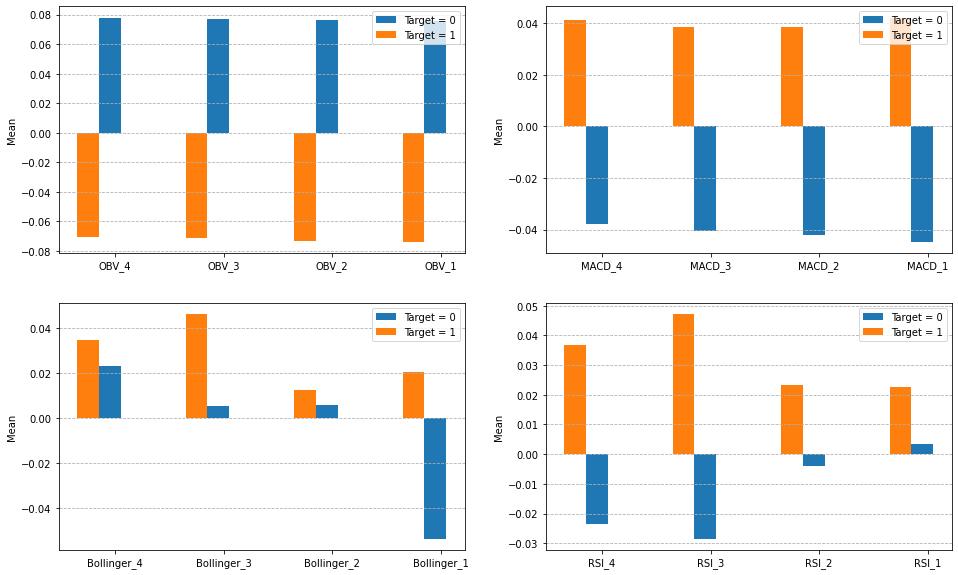

In [6]:
"""
Feature vs. Target 
"""

df = preprocessing("MSFT")

y = df.Target

drop_cols = [c for c in df.columns if "_5" in c]
X = df.drop(drop_cols, axis=1)

# OBV
fig, ax = plt.subplots(2,2,figsize=(16,10))

obv_cols = [c for c in X.columns if "OBV" in c]
obv_0 = X[obv_cols][y == 0].describe().loc['mean']
obv_1 = X[obv_cols][y == 1].describe().loc['mean']

x_range = np.arange(len(obv_0.index))

ax[0][0].bar(x_range + 0.1, obv_0, width=0.2, label="Target = 0")
ax[0][0].bar(x_range - 0.1, obv_1, width=0.2, label="Target = 1")
ax[0][0].set_xticks(x_range + 0.15)
ax[0][0].set_xticklabels(obv_0.index)
ax[0][0].set_ylabel("Mean")
ax[0][0].legend()

ax[0][0].grid(True, "major", "y", ls="--")

# MACD
macd_cols = [c for c in X.columns if "MACD" in c]
macd_0 = X[macd_cols][y == 0].describe().loc['mean']
macd_1 = X[macd_cols][y == 1].describe().loc['mean']

x_range = np.arange(len(macd_0.index))

ax[0][1].bar(x_range + 0.1, macd_0, width=0.2, label="Target = 0")
ax[0][1].bar(x_range - 0.1, macd_1, width=0.2, label="Target = 1")
ax[0][1].set_xticks(x_range + 0.15)
ax[0][1].set_xticklabels(macd_0.index)
ax[0][1].set_ylabel("Mean")
ax[0][1].legend()

ax[0][1].grid(True, "major", "y", ls="--")

# RSI
rsi_cols = [c for c in X.columns if "RSI" in c]
rsi_0 = X[rsi_cols][y == 0].describe().loc['mean']
rsi_1 = X[rsi_cols][y == 1].describe().loc['mean']

x_range = np.arange(len(rsi_0.index))

ax[1][1].bar(x_range + 0.1, rsi_0, width=0.2, label="Target = 0")
ax[1][1].bar(x_range - 0.1, rsi_1, width=0.2, label="Target = 1")
ax[1][1].set_xticks(x_range + 0.15)
ax[1][1].set_xticklabels(rsi_0.index)
ax[1][1].set_ylabel("Mean")
ax[1][1].legend()

ax[1][1].grid(True, "major", "y", ls="--")

# Bollinger
bol_cols = [c for c in X.columns if "Bollinger" in c]
bol_0 = X[bol_cols][y == 0].describe().loc['mean']
bol_1 = X[bol_cols][y == 1].describe().loc['mean']

x_range = np.arange(len(bol_0.index))

ax[1][0].bar(x_range + 0.1, bol_0, width=0.2, label="Target = 0")
ax[1][0].bar(x_range - 0.1, bol_1, width=0.2, label="Target = 1")
ax[1][0].set_xticks(x_range + 0.15)
ax[1][0].set_xticklabels(bol_0.index)
ax[1][0].set_ylabel("Mean")
ax[1][0].legend()

ax[1][0].grid(True, "major", "y", ls="--")

plt.show()


We can observe that based on the target (1 or 0), our feature variables display differences in the mean.


In [7]:
"""
Logistic regression
"""
def logistic_regression(X_train, y_train):

    logreg = LogisticRegression(class_weight={0: 821, 1: 958})
    grid={"C":np.logspace(-5,5,10)}
    logreg_cv = GridSearchCV(logreg,grid,cv=5)
    logreg_cv.fit(X_train,y_train)

    logreg.fit(X_train, y_train)
    #pred = logreg.predict(X_test)
    #print("Test accuracy: ", accuracy_score(pred, y_test))

    return logreg

In [8]:
"""
Random Forest
"""
def random_forest(X_train, y_train, show=False):

    rfc=RandomForestClassifier()
    rf_params = {
        'n_estimators': [20, 50, 100],
        'min_samples_split': list(range(2, 4)),
        "min_samples_leaf": list(range(1, 3)),
        "max_depth": [2, 3]
    }

    rf_grid = GridSearchCV(estimator=rfc, param_grid=rf_params)
    rf_grid.fit(X_train, y_train)

    if show:
        print("Best params: ", rf_grid.best_estimator_.get_params())

    best_rf = rf_grid.best_estimator_

    return best_rf

In [9]:
"""
Neural Network 

"""

import torch
import torch.nn.functional as F
import torch.utils.data as data_utils

class FeedForward(torch.nn.Module):
    def __init__(self, input_size, hidden_dim):
        """
        In the constructor we instantiate two nn.Linear modules and 
        assign them as member variables.
        """
        super(FeedForward, self).__init__()
        self.lin_1 = torch.nn.Linear(input_size, hidden_dim)
        self.lin_2 = torch.nn.Linear(hidden_dim, 2)

    def forward(self, x):
        """
        Compute the forward pass of our model, which outputs logits.
        """
        x = self.lin_1(x)
        x = F.relu(x)
        x = self.lin_2(x)

        return x

    def predict(self, X_test):
        x = torch.from_numpy(np.array(X_test).astype(np.float32))
        logits = self(x)
        pred = torch.max(logits, 1)[1]

        return pred

In [10]:
import torch.optim as optim

def neural_network(X_train, y_train, show=False):

    # initialize
    nn_model = FeedForward(X_train.shape[1], 20)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-5)

    for step in range(1, 50001):
            
        i = np.random.choice(X_train.shape[0], size=int(X_train.shape[0]/10), replace=False)
        x = torch.from_numpy(np.array(X_train.iloc[i]).astype(np.float32))
        y = torch.from_numpy(np.array(y_train.iloc[i]).astype(np.int))

        # Forward pass: Get logits for x
        logits = nn_model(x)
        # Compute loss
        loss = F.cross_entropy(logits, y)
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if show:
            if step % 5000 == 0:
                print("Current Step: ", step)
                idxs = np.random.choice(len(X_train), int(X_train.shape[0]/10), replace=False)
                x = torch.from_numpy(np.array(X_train.iloc[idxs]).astype(np.float32))
                y = torch.from_numpy(np.array(y_train.iloc[idxs]).astype(np.int))
                logits = nn_model(x)
                loss = F.cross_entropy(logits, y)
                y_pred = torch.max(logits, 1)[1]
                print("Training Accuracy: ", accuracy_score(y_train.iloc[idxs], y_pred.numpy()))
                print("Cross Entropy Loss: ", loss.item(), "\n")

    return nn_model


In [11]:
"""
Light GBM Model
"""

import lightgbm as lgb

def light_gbm(X_train, y_train):

    X_train0, X_val= np.split(X_train, [int(0.8 *len(X_train))])
    y_train0, y_val= np.split(y_train, [int(0.8 *len(y_train))])

    train_dataset = lgb.Dataset(X_train0, label=y_train0)
    val_dataset = lgb.Dataset(X_val, label = y_val)

    param = {'num_leaves': 15, 'objective': 'binary'}
    param['metric'] = 'auc'
    num_round = 30
    bst = lgb.train(param, train_dataset, num_round, valid_sets=[val_dataset], verbose_eval=-1)

    return bst



In [12]:
"""
Backtester class
"""

class Backtester:
  def __init__(self, model):
    self.model = model

  # data: data used for prediction
  # price: actual closing prices on each Friday 
  # num_stocks: number of stocks to purchase each time
  def performance(self, data, price, num_stocks = 10):

    if type(self.model).__name__ == "Booster":
        predictions = self.model.predict(data)
        predictions = [1 if i >=0.5 else 0 for i in predictions]
    else:
        predictions = self.model.predict(data)

    profit = 0
    bought = False
    for i in range(len(predictions)):
      
      # Assumption: if the closing price of this Friday shows an increase, then 
      # assume that next week will also increase, so will buy this Friday and
      # sell next Friday no matter what (to simplify things)
      if i == 0:
        profit = profit - num_stocks * price[i]
        bought = True
        continue
      else:
        if bought:
          profit = profit + num_stocks * price[i]
          bought = False
        if i == len(predictions):
          break
        if predictions[i] == 1:
          profit = profit - num_stocks * price[i]
          bought = True
    
    return profit, predictions

In [13]:
"""
Test with backtester - Test multiple companies
"""
ticker_list = ["MSFT","MCD","TGT"]  # Make a list of ticker symbols for Microsoft, McDonald's, Target
y_list = {}  # Store actual test output for each company
pred_list = {}  # Store prediction result for each company and each model 

for ticker in ticker_list:
    df = preprocessing(ticker)

    y = df["Target"]

    # Before we test our models, we want to find a baseline accuracy for our 
    # dataset by using the Zero Rule algorithm which predicts the most common 
    # class value for every entry.
    for i in np.unique(y):
        print(f'{len(y[y==i])} examples of class {i}')

    val = y.mode()[0]
    accuracy = len(y[y==val]) / len(y)
    print("Baseline accuracy: ", accuracy, "\n")

    drop_cols = [c for c in df.columns if "_5" in c]
    X = df.drop(drop_cols, axis=1)
    X = X.drop("Target", axis=1)

    X_train, X_test= np.split(X, [int(0.9 *len(X))])
    y_train, y_test= np.split(y, [int(0.9 *len(y))])
    y_list[ticker] = y_test

    # Train each model
    logreg = logistic_regression(X_train, y_train)
    rfc = random_forest(X_train, y_train)
    nn_model = neural_network(X_train, y_train)
    lgbm = light_gbm(X_train, y_train)

    # Make a list of trained models
    model_list = [logreg, rfc, nn_model, lgbm]

    # Measure performances of each model with the back tester
    for model in model_list:
        tester = Backtester(model)
        price = df.loc[y_test.index]['Close_5']

        profit, pred = tester.performance(X_test, price)
        print("Our projected profit with", type(model).__name__, "for", ticker, "is: ", profit)
        print("Test Accuracy: ", accuracy_score(pred, y_test), "\n")

        # Store the predicted value 
        if ticker not in pred_list:
            pred_list[ticker] = [pred]
        else:
            pred_list[ticker].append(pred)

[*********************100%***********************]  1 of 1 completed
695 examples of class 0
860 examples of class 1
Baseline accuracy:  0.5530546623794212 

Our projected profit with LogisticRegression for MSFT is:  -977.0
Test Accuracy:  0.6346153846153846 

Our projected profit with RandomForestClassifier for MSFT is:  -1040.7999999999993
Test Accuracy:  0.6474358974358975 

Our projected profit with FeedForward for MSFT is:  31.0
Test Accuracy:  0.3717948717948718 

Our projected profit with Booster for MSFT is:  973.800000000002
Test Accuracy:  0.5128205128205128 

[*********************100%***********************]  1 of 1 completed
1107 examples of class 0
1286 examples of class 1
Baseline accuracy:  0.5374007521938988 

Our projected profit with LogisticRegression for MCD is:  -1232.5
Test Accuracy:  0.5875 

Our projected profit with RandomForestClassifier for MCD is:  300.7000000000007
Test Accuracy:  0.4583333333333333 

Our projected profit with FeedForward for MCD is:  654.

In [14]:
"""
Display Confusion Matrices - to see precision/recall
"""
for i in range(4): 
    print("Confusion Matrices for", type(model_list[i]).__name__)
    for ticker in ticker_list:
        print("<", ticker, ">")
        matrix = confusion_matrix(y_list[ticker], pred_list[ticker][i], labels=[1,0])
        display(matrix)
        precision_up = matrix[0,0] / np.sum(matrix[:,0])
        print("Up Precision:", precision_up, "\n")



Confusion Matrices for LogisticRegression
< MSFT >


array([[99,  0],
       [57,  0]])

Up Precision: 0.6346153846153846 

< MCD >


array([[141,   0],
       [ 99,   0]])

Up Precision: 0.5875 

< TGT >


array([[118,   7],
       [ 83,   5]])

Up Precision: 0.5870646766169154 

Confusion Matrices for RandomForestClassifier
< MSFT >


array([[95,  4],
       [51,  6]])

Up Precision: 0.6506849315068494 

< MCD >


array([[ 40, 101],
       [ 29,  70]])

Up Precision: 0.5797101449275363 

< TGT >


array([[57, 68],
       [34, 54]])

Up Precision: 0.6263736263736264 

Confusion Matrices for FeedForward
< MSFT >


array([[ 1, 98],
       [ 0, 57]])

Up Precision: 1.0 

< MCD >


array([[ 15, 126],
       [ 10,  89]])

Up Precision: 0.6 

< TGT >


array([[  4, 121],
       [  4,  84]])

Up Precision: 0.5 

Confusion Matrices for Booster
< MSFT >


array([[43, 56],
       [20, 37]])

Up Precision: 0.6825396825396826 

< MCD >


array([[  4, 137],
       [  1,  98]])

Up Precision: 0.8 

< TGT >


array([[68, 57],
       [50, 38]])

Up Precision: 0.576271186440678 



[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


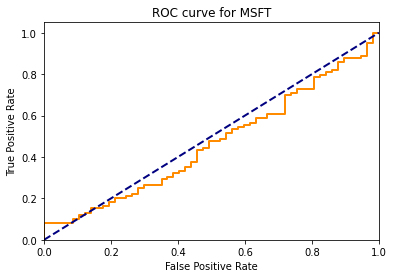

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


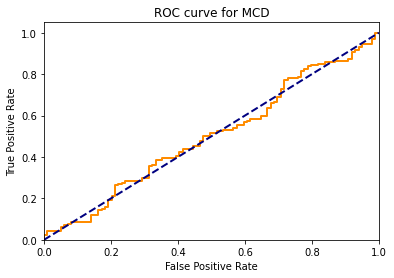

[*********************100%***********************]  1 of 1 completed


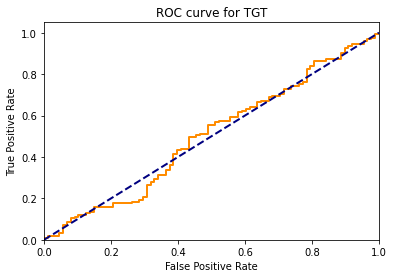

In [15]:
"""
ROC Curve for Logistic Regression
"""

for ticker in ticker_list:
    df = preprocessing(ticker)
    y = df["Target"]
    
    drop_cols = [c for c in df.columns if "_5" in c]
    X = df.drop(drop_cols, axis=1)
    X = X.drop("Target", axis=1)
    X_train, X_test= np.split(X, [int(0.9 *len(X))])
    y_train, y_test= np.split(y, [int(0.9 *len(y))])
    
    logreg = logistic_regression(X_train, y_train)
    pred = logreg.predict(X_test)

    precision_recall_fscore_support(y_test, pred)
    prob = logreg.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, prob)

    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(str("ROC curve for " + ticker))
    plt.show()